## Sales Forecasting using Walmart Dataset


In [1]:
# Import required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from xgboost.plotting import plot_importance
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

### Setup and Initial Data Exploration

In [2]:
# Download the Walmart Sales Forecast dataset from Kaggle
path= kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
print("Path to dataset files:", path)

# Check top-level files/folders
print('\nFiles: ', os.listdir(path))

# Load all files
def load_csv(filename):
    file_path= os.path.join(path,filename)
    df= pd.read_csv(file_path)
    print(f"\nLoaded {filename}\n shape: {df.shape}")
    return df

train= load_csv('train.csv')
test= load_csv('test.csv')
features= load_csv('features.csv')
stores= load_csv('stores.csv')

# Merge store info into features
features= features.merge(stores, on= ['Store'], how= 'left')

# Merge features with train and test data
train= train.merge(features, on= ['Store', 'Date'], how= 'left')
test= test.merge(features, on= ['Store', 'Date'], how= 'left')

print("\nTrain set: ", train.shape)
print("Test set: ", test.shape)




Path to dataset files: C:\Users\Tasneem\.cache\kagglehub\datasets\aslanahmedov\walmart-sales-forecast\versions\1

Files:  ['features.csv', 'stores.csv', 'test.csv', 'train.csv']

Loaded train.csv
 shape: (421570, 5)

Loaded test.csv
 shape: (115064, 4)

Loaded features.csv
 shape: (8190, 12)

Loaded stores.csv
 shape: (45, 3)

Train set:  (421570, 17)
Test set:  (115064, 16)


### Data Overview and Quality Checks

In [3]:
# Inspect dataset structure
train.info()
train.head()

# Check for missing values
print("\nMissing values:\n",train.isna().sum().sort_values(ascending=False).head(10))

# Check for duplicates
print("\nDuplicates:", train.duplicated().sum())

# Check date coverage
print(f"\nDate range: {train['Date'].min()} → {train['Date'].max()}")

# Examine sales distribution
train['Weekly_Sales'].describe()
      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

### Data Cleaning and Preprocessing

In [4]:
# Handle missing values in markdown features
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    train[col] = train[col].astype(float).fillna(0)
    test[col] = test[col].astype(float).fillna(0)

print("Missing values after filling (train):")
print(train[markdown_cols].isna().sum())
print("\nMissing values after filling (test):")
print(test[markdown_cols].isna().sum())

# Convert 'Date' to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

print("\nData type of 'Date' column (train):", train['Date'].dtype)
print("Data type of 'Date' column (test):", test['Date'].dtype)


Missing values after filling (train):
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64

Missing values after filling (test):
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64

Data type of 'Date' column (train): datetime64[ns]
Data type of 'Date' column (test): datetime64[ns]


### Exploratory Data Analysis (EDA)

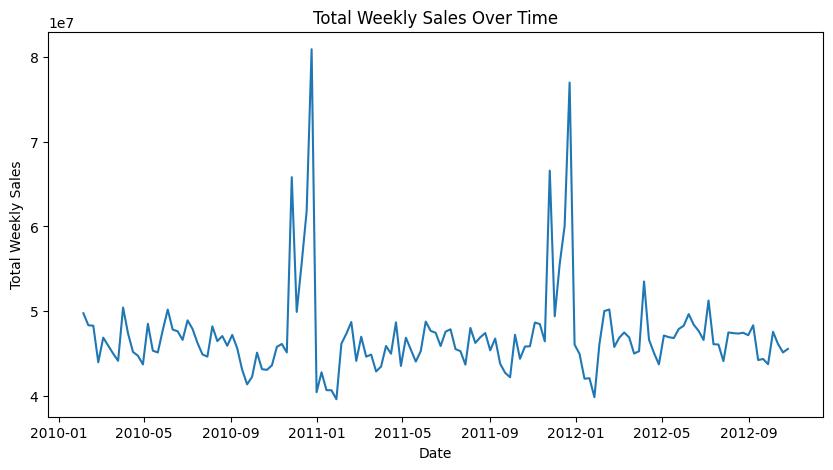

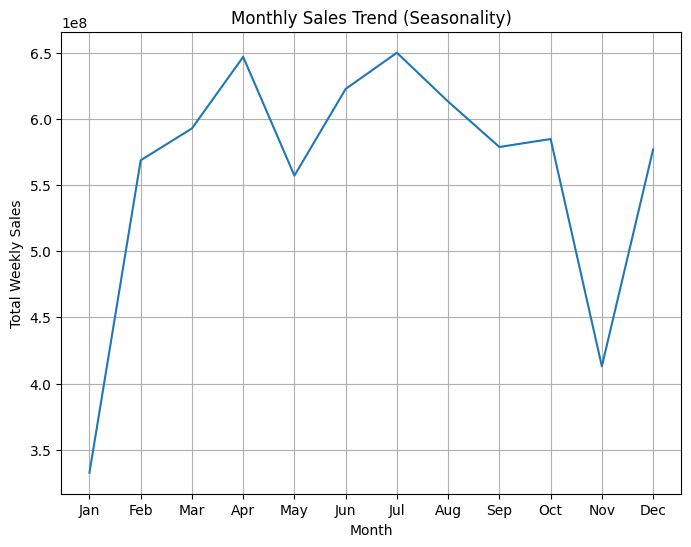

In [5]:
# Perform EDA to identify general sales trends

# Sales trends over time 
sales_over_time= train.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(10,5))
plt.plot(sales_over_time.index, sales_over_time.values)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

# Monthly sales trend (seasonality)
train['Month']= train['Date'].dt.month
monthly_sales= train.groupby('Month')['Weekly_Sales'].sum()

plt.figure(figsize=(8,6))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Monthly Sales Trend (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Total Weekly Sales')
plt.xticks(range(1,13), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True)
plt.show()


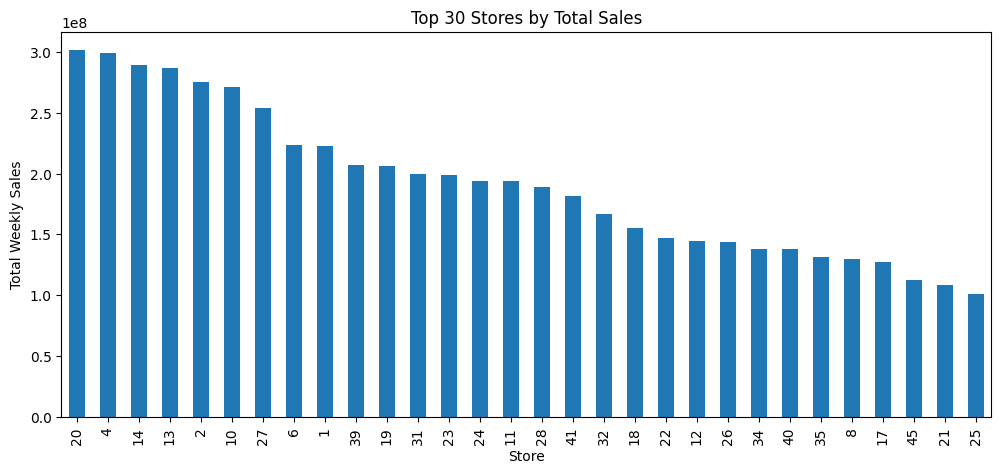

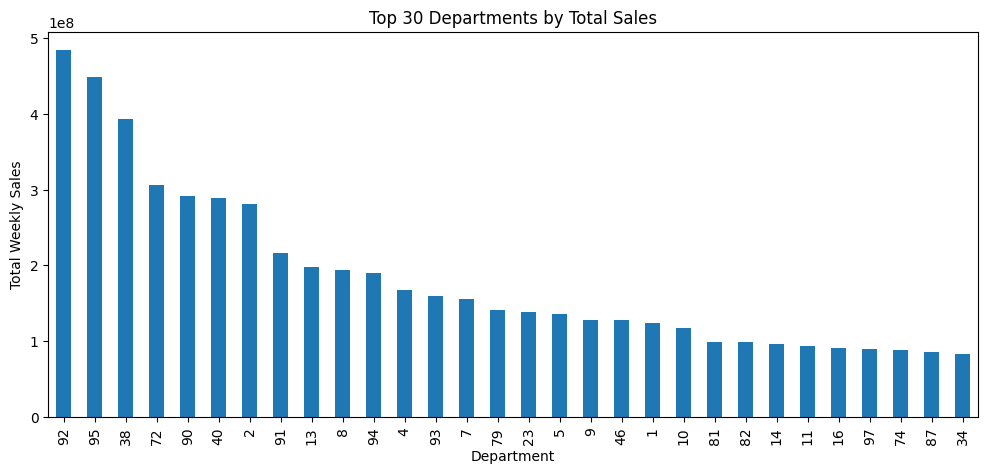

In [6]:
# Explore sales patterns by store and department

# Analyze total sales across top stores
store_sales= train.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
top_stores = 30  # top 30 stores
plt.figure(figsize=(12, 5))
store_sales.head(top_stores).plot(kind='bar')
plt.title(f'Top {top_stores} Stores by Total Sales')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.show()

# Analyze total sales across top departments
dept_sales = train.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
top_depts = 30  # top 30 departments
plt.figure(figsize=(12, 5))
dept_sales.head(top_depts).plot(kind='bar')
plt.title(f'Top {top_depts} Departments by Total Sales')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.show()

### Outlier Detection and Handling

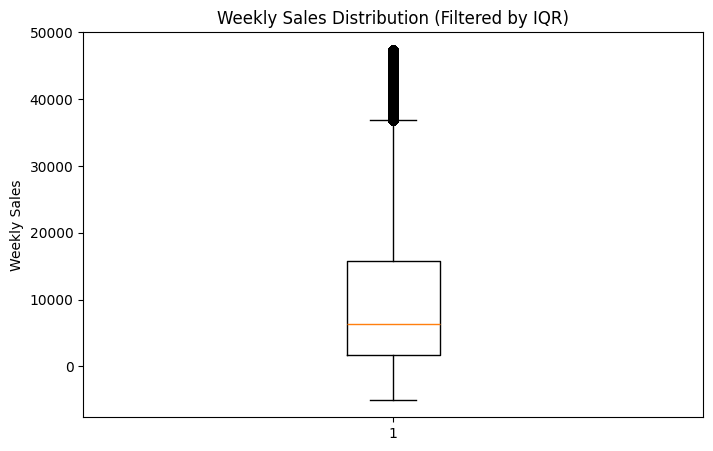

Original dataset size: 421570
After outlier removal: 386049


In [7]:
# Remove extreme outliers using IQR method
Q1 = train['Weekly_Sales'].quantile(0.25)
Q3 = train['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

filtered_sales = train[(train['Weekly_Sales'] >= Q1 - 1.5*IQR) &
                       (train['Weekly_Sales'] <= Q3 + 1.5*IQR)]

plt.figure(figsize=(8,5))
plt.boxplot(filtered_sales['Weekly_Sales'])
plt.title('Weekly Sales Distribution (Filtered by IQR)')
plt.ylabel('Weekly Sales')
plt.show()

# Assign cleaned dataset to train_filtered
train_filtered = filtered_sales.copy() 

print("Original dataset size:", train.shape[0]) 
print("After outlier removal:", train_filtered.shape[0])

### Feature Engineering

In [ ]:
# Extract time-based features
train['Year'] = train['Date'].dt.year
train['Week_of_Year'] = train['Date'].dt.isocalendar().week
train['Day'] = train['Date'].dt.day

# Note: 'Month' feature was already created earlier
#       'IsHoliday' column already indicates holiday weeks


# Create lag and rolling average features
train_filtered = train_filtered.sort_values(['Store', 'Dept', 'Date'])

train_filtered['Sales_lag_1w'] = train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)  
train_filtered['Sales_lag_4w'] = train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)

train_filtered['rolling_mean_4w']= train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(4).mean())
train_filtered['rolling_mean_12w']= train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(12).mean())

# Summarize newly created features
train_filtered[['Sales_lag_1w', 'Sales_lag_4w', 'rolling_mean_4w', 'rolling_mean_12w']].describe().T


,count,mean,std,min,25%,50%,75%,max
Sales_lag_1w,382851.0,10545.753000,11316.018679,-4988.940000,1763.455000,6382.16000,15803.240000,47393.4300
Sales_lag_4w,373480.0,10549.136720,11287.520974,-4988.940000,1785.405000,6409.42000,15810.690000,47393.4300
rolling_mean_4w,376574.0,10543.822360,11129.401136,-989.500000,1840.677500,6507.03875,15951.839375,47152.5675
rolling_mean_12w,352278.0,10552.289556,10923.645007,-314.679167,1972.892083,6665.95375,16036.349167,46594.5200


### Train-Validation Split

In [9]:
# Split data chronologically to avoid leakage
X = train_filtered.drop(['Weekly_Sales'], axis=1)
y = train_filtered['Weekly_Sales']

split_date = '2012-06-01'  # reserve later months for validation

X_train = X[train_filtered['Date'] < split_date]
X_val = X[train_filtered['Date'] >= split_date]
y_train = y[train_filtered['Date'] < split_date]
y_val = y[train_filtered['Date'] >= split_date]

# Verify there’s no leakage
print(f"Train range: {X_train['Date'].dt.date.min()} → {X_train['Date'].dt.date.max()}")
print(f"Valid range: {X_val['Date'].dt.date.min()} → {X_val['Date'].dt.date.max()}")


Train range: 2010-02-05 → 2012-05-25
Valid range: 2012-06-01 → 2012-10-26


In [10]:
# Drop 'Date' column before modeling — time features already extracted
X_train_model = X_train.drop('Date', axis=1)
X_val_model = X_val.drop('Date', axis=1)

# One-hot encode categorical features
categorical_cols = ['Store', 'Dept', 'Type']
X_train_model = pd.get_dummies(X_train_model, columns=categorical_cols, drop_first=True)
X_val_model = pd.get_dummies(X_val_model, columns=categorical_cols, drop_first=True)

# Align columns across splits
X_val_model = X_val_model.reindex(columns=X_train_model.columns, fill_value=0)

# Fill NaNs caused by lag/rolling features
X_train_filled = X_train_model.fillna(0)
X_val_filled = X_val_model.fillna(0)


### Model Development (Baseline and Regression Models)

In [11]:
# Baseline model using last week's sales
baseline_pred = X_val['Sales_lag_1w'].fillna(0)
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))
print(f"Baseline MAE: {baseline_mae:.2f}, RMSE: {baseline_rmse:.2f}")

# Define regression models
model_dict = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1, min_samples_split=2, min_samples_leaf=1)
}

# Initialize prediction and results storage
predictions = {'Baseline': baseline_pred}
results = {'Baseline': {'MAE': baseline_mae, 'RMSE': baseline_rmse}}

# Train and evaluate models
for name, model in model_dict.items():
    model.fit(X_train_filled, y_train)
    pred = model.predict(X_val_filled)
    mae = mean_absolute_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    predictions[name] = pred
    results[name] = {'MAE': mae, 'RMSE': rmse}
    
    print(f"{name} MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Identify best model
best_model_name = min(results, key=lambda k: results[k]['RMSE'])
if best_model_name != 'Baseline':
    print(f"\nBest model: {best_model_name} (lowest RMSE: {results[best_model_name]['RMSE']:.2f}) "
          f"- Shows promising performance but will need tuning for hyperparameters and feature selection.")
else:
    print("\nBaseline performed best - indicates simple lag is strong, but further modeling is recommended.")


Baseline MAE: 1092.80, RMSE: 2103.26
Linear Regression MAE: 1141.56, RMSE: 1896.69
Random Forest MAE: 797.99, RMSE: 1493.71

Best model: Random Forest (lowest RMSE: 1493.71) - Shows promising performance but will need tuning for hyperparameters and feature selection.


### Actual vs Predicted Weekly Sales (Rolling Average Visualization)

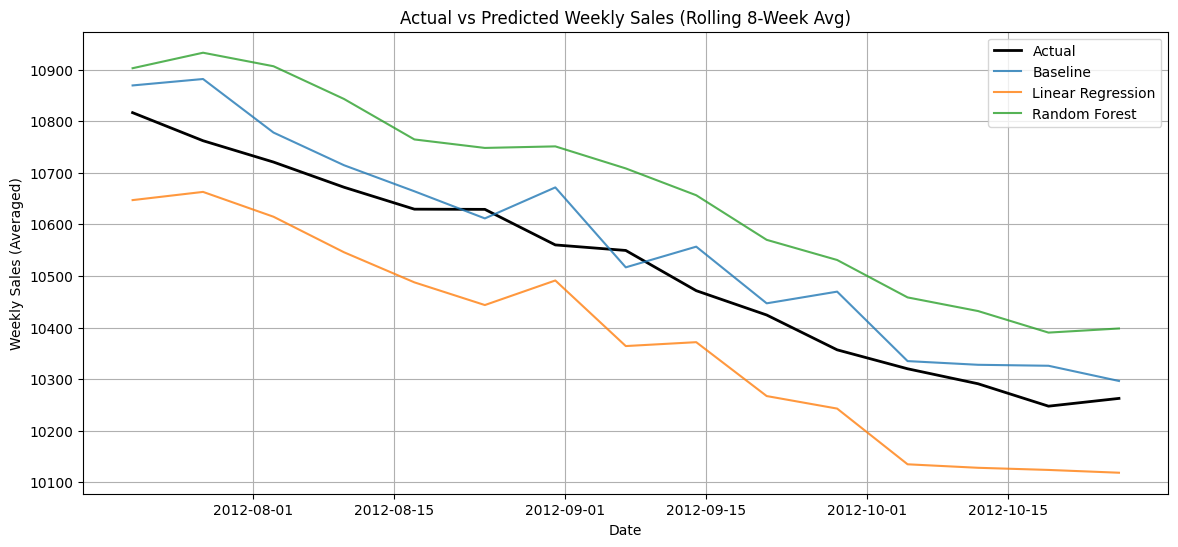

In [12]:
# Aggregate actual and predicted values by date
agg_df = pd.DataFrame({'Date': X_val['Date'], 'Actual': y_val})

# Append model predictions for comparison
for name, pred in predictions.items():
    agg_df[name] = pred

# Compute average weekly sales across all stores and departments
agg_df = agg_df.groupby('Date').mean().reset_index()

# Plot rolling averages for actual vs predicted sales
rolling_window = 8  # rolling window size (in weeks)
plt.figure(figsize=(14, 6))

# Rolling average of actual sales
plt.plot(agg_df['Date'], agg_df['Actual'].rolling(rolling_window).mean(),
         label='Actual', color='black', linewidth=2)

# Rolling average of each model's predictions
for name in predictions.keys():
    plt.plot(agg_df['Date'], agg_df[name].rolling(rolling_window).mean(),
             label=f'{name}', alpha=0.8)

plt.xlabel('Date')
plt.ylabel('Weekly Sales (Averaged)')
plt.title(f'Actual vs Predicted Weekly Sales (Rolling {rolling_window}-Week Avg)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### Advanced Models (XGBoost and LightGBM)

In [13]:
# Define time series cross validation
time_series_cv= TimeSeriesSplit(3)

# Define advanced models with tuned parameters
adv_models={
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.8, 
                            colsample_bytree=0.8, random_state=42, n_jobs=-1),
                            
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.1, num_leaves=31, subsample=0.8, 
                              colsample_bytree=0.8, random_state=42, n_jobs=-1, force_col_wise=True, verbose=-1)
}

#Evaluate models using expanding window validation
for name, model in adv_models.items():
    print(f"\n{name} – Expanding Window Validation:")
    split=1
    for train_idx, val_idx in time_series_cv.split(X_train_model):
        X_t,X_v= X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_t,y_v= y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_t,y_t)
        val_pred= model.predict(X_v)
        mae= mean_absolute_error(y_v,val_pred)
        rmse= np.sqrt(mean_squared_error(y_v,val_pred))
        print(f"\nFold {split}: MAE={mae:.2f}, RMSE={rmse:.2f}")

        split+=1

    # Final training on full training set
    model.fit(X_train_model,y_train)

    # Evaluate final model on validation set
    pred= model.predict(X_val_model)
    predictions[name]=pred
    results[name]={'MAE': mean_absolute_error(y_val,pred),
                   'RMSE': np.sqrt(mean_squared_error(y_val,pred))}
    
    print(f"\n{name} MAE: {results[name]['MAE']:.2f}, RMSE: {results[name]['RMSE']:.2f}")
    


XGBoost – Expanding Window Validation:

Fold 1: MAE=1173.81, RMSE=2138.65

Fold 2: MAE=1041.18, RMSE=1972.59

Fold 3: MAE=828.58, RMSE=1663.64

XGBoost MAE: 805.33, RMSE: 1461.51

LightGBM – Expanding Window Validation:

Fold 1: MAE=1186.71, RMSE=2197.38

Fold 2: MAE=1059.20, RMSE=1956.17

Fold 3: MAE=857.49, RMSE=1729.80

LightGBM MAE: 822.89, RMSE: 1483.38


### Model Performance Summary

Model Performance (sorted by RMSE):


,MAE,RMSE
XGBoost,805.330285,1461.508320
LightGBM,822.888667,1483.381884
Random Forest,797.992533,1493.707904
Linear Regression,1141.560619,1896.692515
Baseline,1092.798412,2103.258561


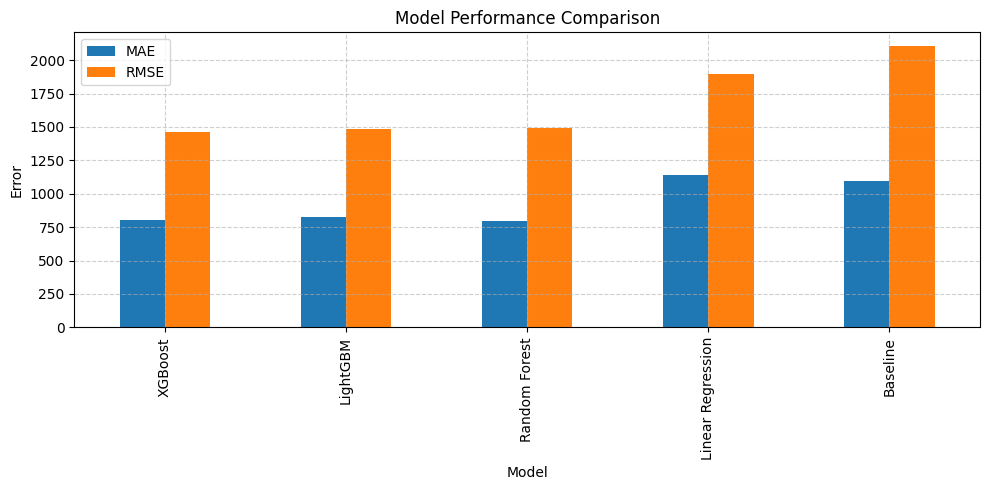

Model Performance Summary saved successfully to: c:\Users\Tasneem\OneDrive\Desktop\Sales_Forecasting\results\model_performance_summary.csv


In [14]:
# Create performance summary DataFrame
results_df= pd.DataFrame(results).T.sort_values('RMSE')

print("Model Performance (sorted by RMSE):")
display(results_df)

# Plot MAE and RMSE comparison
results_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 5), title='Model Performance Comparison')
plt.ylabel('Error')
plt.xlabel('Model')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Export model performance summary as CSV
# Define results folder within project structure
project_path = os.path.dirname(os.getcwd())  # Go one level up from 'src'
results_dir = os.path.join(project_path, 'results')
os.makedirs(results_dir, exist_ok=True)


# Save results to CSV file
results_path = os.path.join(results_dir, 'model_performance_summary.csv')
results_df.to_csv(results_path, index=True)

print(f"Model Performance Summary saved successfully to: {results_path}")


### Feature Importance Visualization


Feature Importance for XGBoost:


<Figure size 1000x800 with 0 Axes>

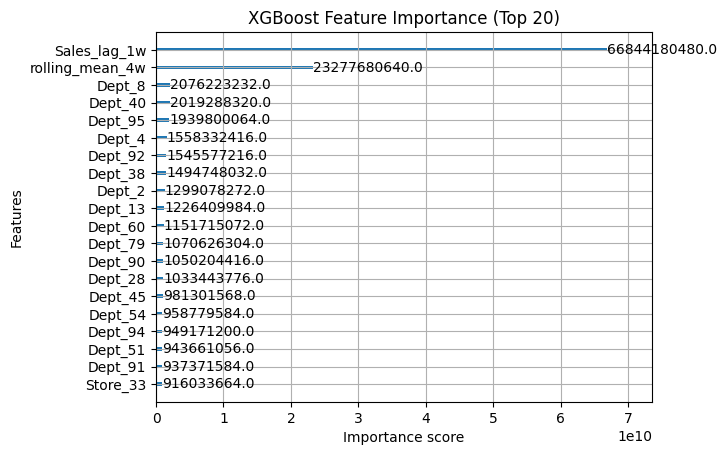


Feature Importance for LightGBM:


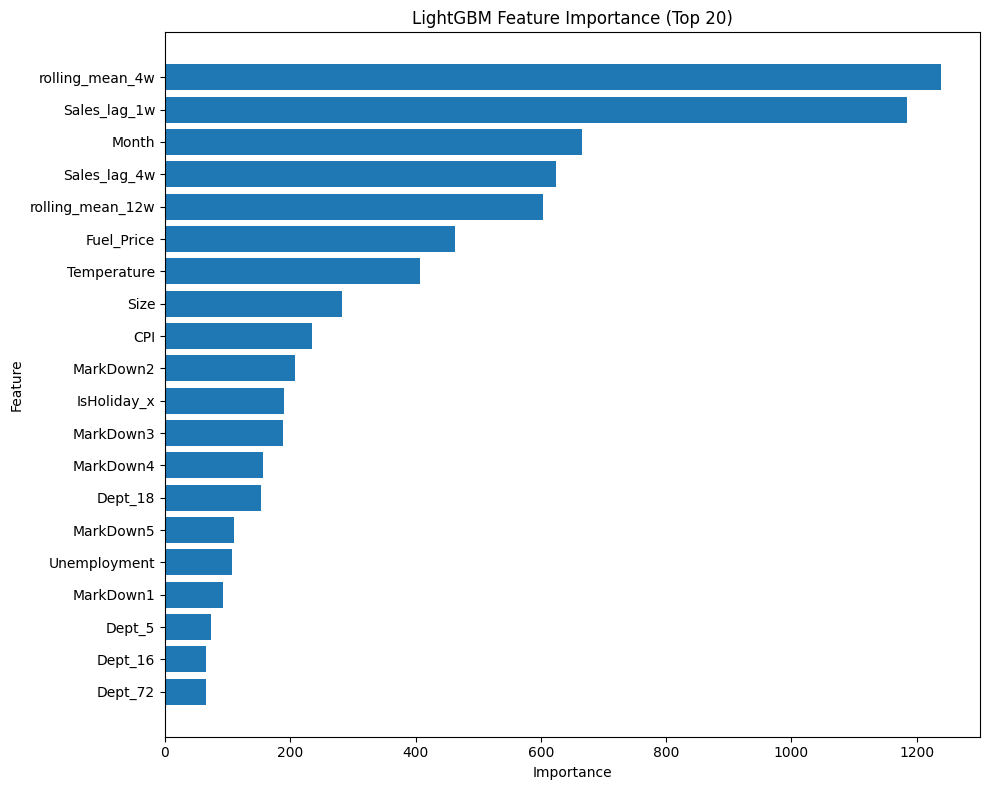

In [15]:
# Display feature importance for advanced models
for name, model in adv_models.items():
    print(f"\nFeature Importance for {name}:")

    plt.figure(figsize=(10, 8))

    if name == 'XGBoost':
        # Use XGBoost’s built-in plot
        plot_importance(model, importance_type= 'gain', max_num_features=20)
        plt.title(f'{name} Feature Importance (Top 20)')
        plt.show()

    if name == 'LightGBM':
        # Manually build bar plot for LightGBM
        feat_imp= pd.DataFrame({
            'Feature': model.feature_name_,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.barh(feat_imp['Feature'][:20][::-1], feat_imp['Importance'][:20][::-1])
        plt.title(f'{name} Feature Importance (Top 20)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        

### Insights and Visualization

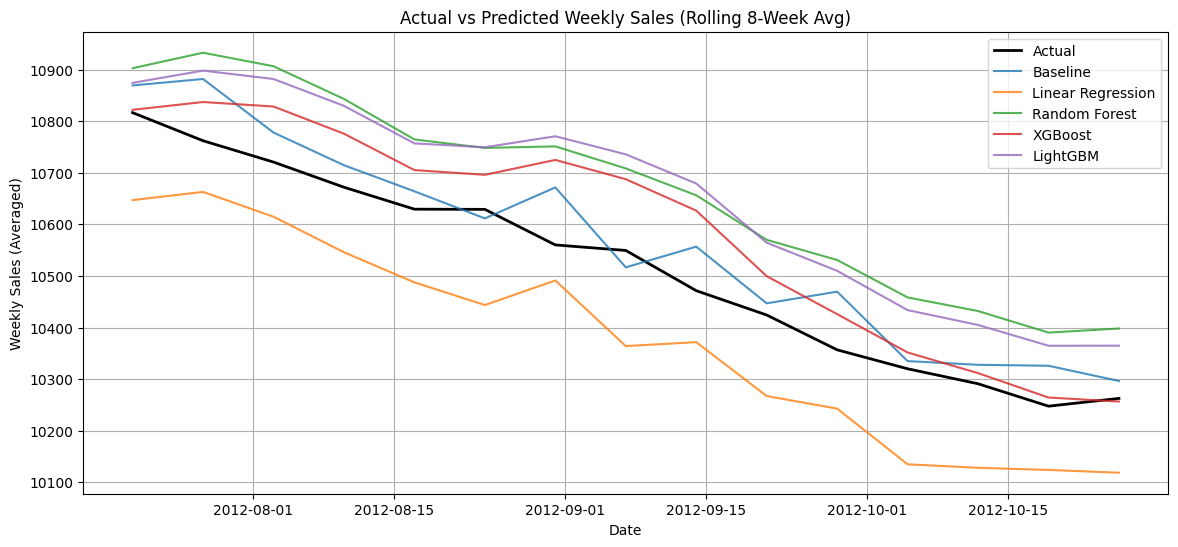

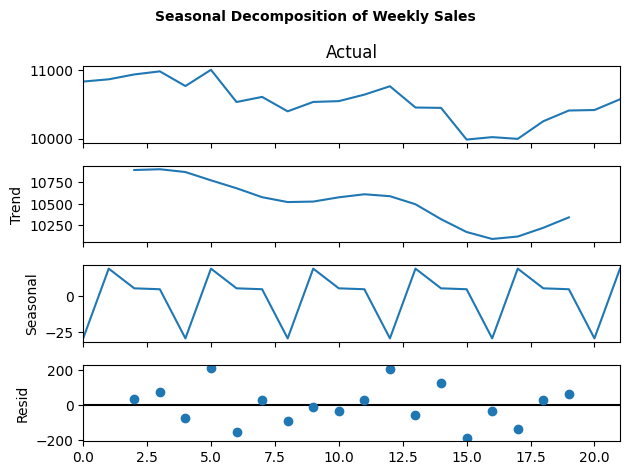

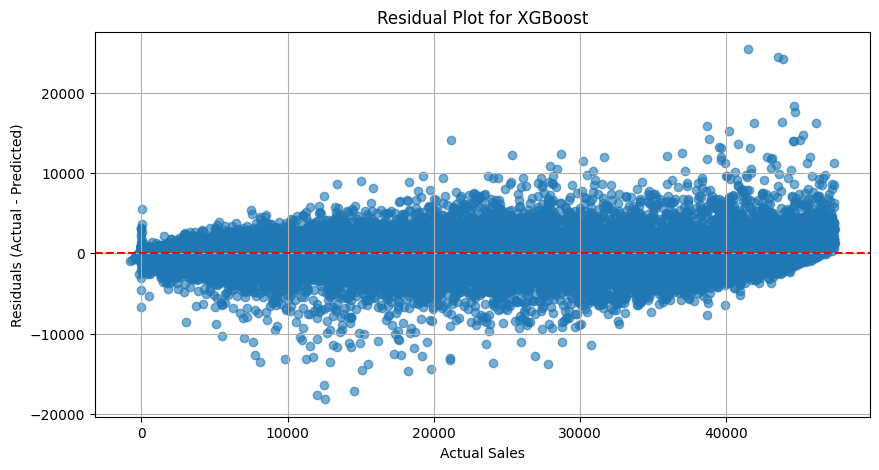

In [16]:
# Rebuild aggregated DataFrame to include predictions from advanced models
agg_df = pd.DataFrame({'Date': X_val['Date'], 'Actual': y_val})
for name, pred in predictions.items():
    agg_df[name] = pred
agg_df = agg_df.groupby('Date').mean().reset_index()

rolling_window = 8 
plt.figure(figsize=(14, 6))

# Rolling average of actual sales
plt.plot(agg_df['Date'], agg_df['Actual'].rolling(rolling_window).mean(),
         label='Actual', color='black', linewidth=2)

# Rolling average of each model's predictions
for name in predictions.keys():
    plt.plot(agg_df['Date'], agg_df[name].rolling(rolling_window).mean(),
             label=f'{name}', alpha=0.8)

plt.xlabel('Date')
plt.ylabel('Weekly Sales (Averaged)')
plt.title(f'Actual vs Predicted Weekly Sales (Rolling {rolling_window}-Week Avg)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Perform seasonal decomposition on actual sales
decomp= seasonal_decompose(agg_df['Actual'], model='additive', period=4)
decomp.plot()
plt.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot residuals for the best model
best_model_name = results_df.index[0]  # Gets the first row (lowest RMSE)
best_pred = predictions[best_model_name]

residuals = y_val - best_pred

plt.figure(figsize=(10,5))
plt.scatter(y_val, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()